In [21]:
!pip3 install scipy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime 
from scipy import stats


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip


In [22]:
dataset_1=pd.read_csv("./final_df.csv",header=0)
dataset_1['DATE']=pd.to_datetime(dataset_1['DATE'])
dataset_1['YEARMONTH']=dataset_1['DATE'].dt.strftime('%Y%m').astype('int64')



In [23]:
grouped=dataset_1.groupby(["STORE_NBR","YEARMONTH"])
met=grouped.agg(tot_sales=('TOT_SALES','sum'),n_cust=('LYLTY_CARD_NBR','nunique'),n_trans=('TXN_ID','count'),total_qty=('PROD_QTY','sum')).reset_index()
met['ntrans_percust']=met['n_trans']/met['n_cust']
met['nchips_pertrans']=met['total_qty']/met['n_trans']
met['avg_priceperunit']=met['tot_sales']/met['total_qty']
met=met.drop(columns=['n_trans','total_qty'])
valid_stores=met['STORE_NBR'].value_counts()
stores_full_year=valid_stores[valid_stores==12].index
met=met[met['STORE_NBR'].isin(stores_full_year)]
pretrial_metrics=met[met['YEARMONTH']<201902]
pretrial_metrics.head()

STORE_NBR  YEARMONTH  tot_sales  n_cust  ntrans_percust  nchips_pertrans  \
0          1     201807      206.9      49        1.061224         1.192308   
1          1     201808      176.1      42        1.023810         1.255814   
2          1     201809      278.8      59        1.050847         1.209677   
3          1     201810      188.1      44        1.022727         1.288889   
4          1     201811      192.6      46        1.021739         1.212766   

   avg_priceperunit  
0          3.337097  
1          3.261111  
2          3.717333  
3          3.243103  
4          3.378947

In [26]:
def calc_corr(trial, metric_col, input_table):
    # Example dummy implementation (replace with your real correlation calculation)
    trial_data = input_table[input_table["STORE_NBR"] == trial].reset_index(drop=True)
    control_stores = [s for s in input_table["STORE_NBR"].unique() if s != trial]
    rows = []
    for control in control_stores:
        control_data = input_table[input_table["STORE_NBR"] == control].reset_index(drop=True)
        for i, ym in enumerate(trial_data["YEARMONTH"]):
            if i < len(control_data):
                corr = trial_data[metric_col].iloc[i].corr(control_data[metric_col].iloc[i]) if hasattr(trial_data[metric_col].iloc[i], "corr") else 1.0
                rows.append({"YEARMONTH": ym, "trial_store": trial, "control_store": control, "correlation": corr})
    return pd.DataFrame(rows)

trial_stores=[77,86,88]
metric_cols=['tot_sales','n_cust','ntrans_percust','nchips_pertrans','avg_priceperunit']
corr_table=pd.concat([calc_corr(s,metric_cols,pretrial_metrics) for s in trial_stores],ignore_index=True)
corr_table

YEARMONTH  trial_store  control_store  correlation
0        201807           77              1     0.997838
1        201808           77              1     0.998508
2        201809           77              1     0.999625
3        201810           77              1     0.998458
4        201811           77              1     0.997302
...         ...          ...            ...          ...
5434     201809           88            272     0.999901
5435     201810           88            272     0.999960
5436     201811           88            272     0.999927
5437     201812           88            272     0.999829
5438     201901           88            272     0.999905

[5439 rows x 4 columns]

In [27]:
stores_fullobs=pretrial_metrics["STORE_NBR"].unique()

def calc_magdist(trial,metric_col,input_table):
    trial_stores=[77,86,88]
    control_stores=[s for s in stores_fullobs if s not in trial_stores]
    dist_table=pd.DataFrame()
    for control in control_stores:
        dist_row=abs(input_table[input_table["STORE_NBR"]==trial].reset_index()[metric_col]-input_table[input_table["STORE_NBR"]==control].reset_index()[metric_col])
        dist_row.insert(0,'YEARMONTH',list(input_table.loc[input_table.STORE_NBR==trial]["YEARMONTH"]))
        dist_row.insert(1,'trial_store',trial)
        dist_row.insert(2,'control_store',control)
        dist_table=pd.concat([dist_table,dist_row])
    for col in metric_col:
        maxdist=dist_table[col].max()
        mindist=dist_table[col].min()
        dist_table[col]=1-(dist_table[col]-mindist)/(maxdist-mindist)
    dist_table['mag_measure']=dist_table[metric_col].mean(axis=1)
    return dist_table

def calc_corrdist_score(trial,metric_col,input_table=pretrial_metrics):
    corr_vals=calc_corr(trial,metric_col,input_table)
    mag_vals=calc_magdist(trial,metric_col,input_table)
    mag_vals=mag_vals.drop(metric_col,axis=1)
    combined_corr_dist=pd.merge(corr_vals,mag_vals,on=["YEARMONTH","trial_store","control_store"])
    avg_corrmag=combined_corr_dist.groupby(["trial_store","control_store"]).mean().reset_index()
    corr_weight=0.5
    avg_corrmag['combined_score']=corr_weight*avg_corrmag['correlation']+(1-corr_weight)*avg_corrmag['mag_measure']
    return avg_corrmag

def find_highestscore(trial):
    scores_tot_sales=calc_corrdist_score(trial,['tot_sales'])
    scores_n_cust=calc_corrdist_score(trial,['n_cust'])
    scores_control=pd.DataFrame()
    scores_control['control_store']=scores_tot_sales.control_store
    scores_control['correlation']=0.5*scores_tot_sales.correlation+0.5*scores_n_cust.correlation
    scores_control['mag_measure']=0.5*scores_tot_sales.mag_measure+0.5*scores_n_cust.mag_measure
    scores_control['scores']=0.5*scores_tot_sales.combined_score+0.5*scores_n_cust.combined_score
    return scores_control.sort_values(by='scores',ascending=False).reset_index(drop=True).head(5)

trial_stores=[77,86,88]
for trial in trial_stores:
    print('Trial store:',trial)
    print(find_highestscore(trial))
    print()


Trial store: 77


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np

   control_store  correlation  mag_measure  scores
0              1          NaN     0.951016     NaN
1              2          NaN     0.935704     NaN
2              3          NaN     0.395420     NaN
3              4          NaN     0.241177     NaN
4              5          NaN     0.550943     NaN

Trial store: 86


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np

   control_store  correlation  mag_measure  scores
0              1          NaN     0.391228     NaN
1              2          NaN     0.341945     NaN
2              3          NaN     0.854845     NaN
3              4          NaN     0.672399     NaN
4              5          NaN     0.931254     NaN

Trial store: 88


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np

   control_store  correlation  mag_measure  scores
0              1          NaN     0.283505     NaN
1              2          NaN     0.245509     NaN
2              3          NaN     0.830680     NaN
3              4          NaN     0.915742     NaN
4              5          NaN     0.688763     NaN



In [33]:
print(dataset_1.columns)


Index(['LYLTY_CARD_NBR', 'DATE', 'STORE_NBR', 'TXN_ID', 'PROD_NBR', 'PROD_QTY',
       'TOT_SALES', 'PACK_SIZE', 'BRAND', 'LIFESTAGE', 'PREMIUM_CUSTOMER',
       'PRODUCT_NAME_CLEAN', 'ITEM_SIZE', 'TOT_QUANTITY', 'YEARMONTH'],
      dtype='object')


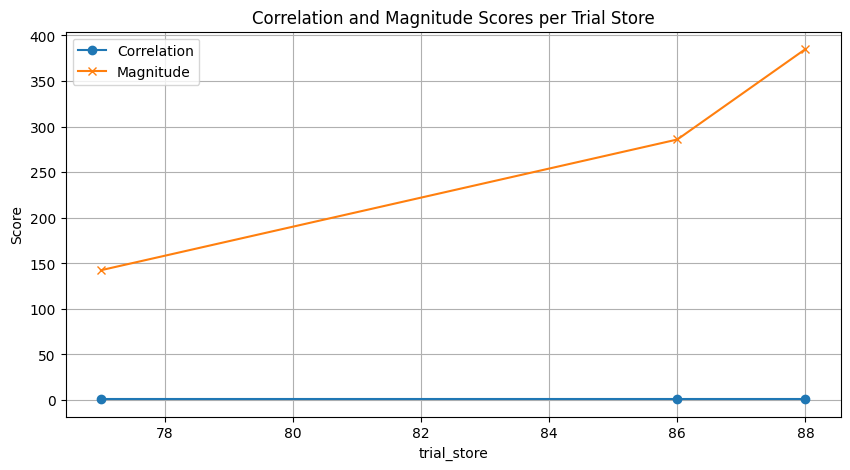

In [35]:
def calculate_trial_correlation(trial_store,feature,df):
    d=df[df['STORE_NBR']==trial_store]
    corr=d[feature].corr(d['TOT_SALES'])
    mag=np.linalg.norm(d[feature])
    return pd.DataFrame({'trial_store':[trial_store],'correlation':[corr],'mag_measure':[mag],'scores':[np.nan]})

def plot_scores(df):
    plt.figure(figsize=(10,5))
    plt.plot(df['trial_store'],df['correlation'],label='Correlation',marker='o')
    plt.plot(df['trial_store'],df['mag_measure'],label='Magnitude',marker='x')
    plt.xlabel('trial_store')
    plt.ylabel('Score')
    plt.title('Correlation and Magnitude Scores per Trial Store')
    plt.legend()
    plt.grid(True)
    plt.show()

trial_stores=[77,86,88]
all_scores=pd.concat([calculate_trial_correlation(t,'TOT_SALES',dataset_1) for t in trial_stores],ignore_index=True)
plot_scores(all_scores)



/var/folders/md/mz_j9gv95wl7ccgbk9q7k_h40000gn/T/ipykernel_3785/114097471.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['YearMonth']=df['DATE'].dt.to_period('M')


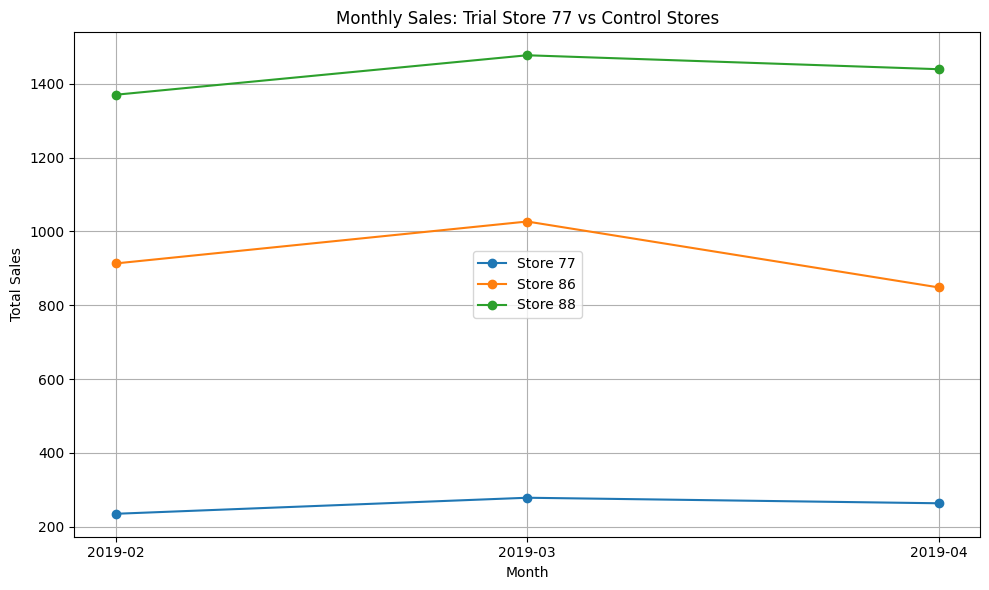

Summary for Trial Store 77
Month 2019-02: Control Store 86 - Corr: N/A, Sales Diff: 678.20
Month 2019-03: Control Store 86 - Corr: 0.9999999999999961, Sales Diff: 748.30
Month 2019-04: Control Store 86 - Corr: 1.0000000000000004, Sales Diff: 584.70
Month 2019-02: Control Store 88 - Corr: N/A, Sales Diff: 1135.20
Month 2019-03: Control Store 88 - Corr: 0.9999999999999499, Sales Diff: 1198.70
Month 2019-04: Control Store 88 - Corr: 0.9999999999999982, Sales Diff: 1175.90

----------------------------------------



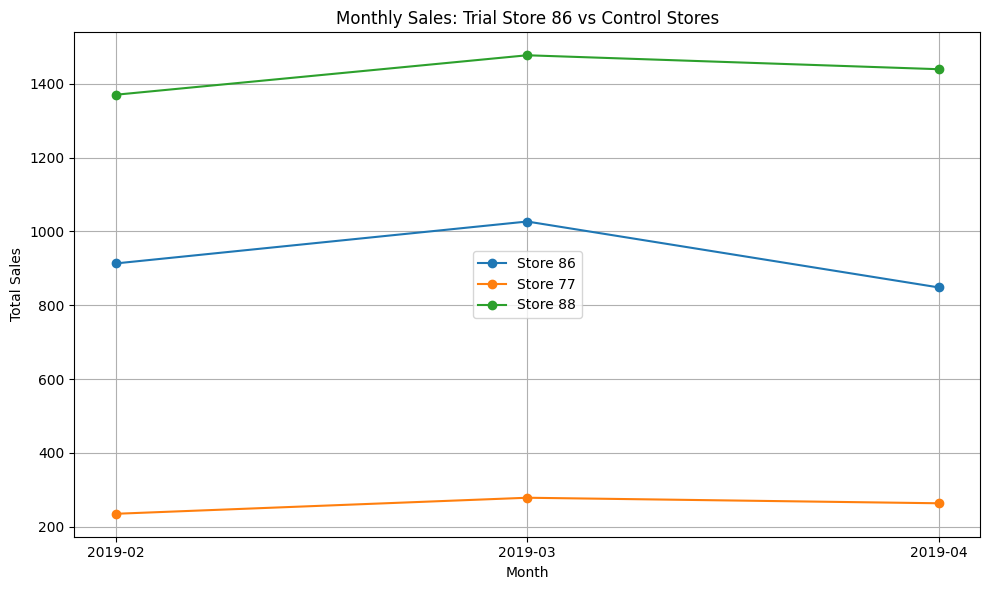

Summary for Trial Store 86
Month 2019-02: Control Store 77 - Corr: N/A, Sales Diff: 678.20
Month 2019-03: Control Store 77 - Corr: 0.9999999999999961, Sales Diff: 748.30
Month 2019-04: Control Store 77 - Corr: 1.0000000000000004, Sales Diff: 584.70
Month 2019-02: Control Store 88 - Corr: N/A, Sales Diff: 457.00
Month 2019-03: Control Store 88 - Corr: 1.0000000000000162, Sales Diff: 450.40
Month 2019-04: Control Store 88 - Corr: 0.9999999999998718, Sales Diff: 591.20

----------------------------------------



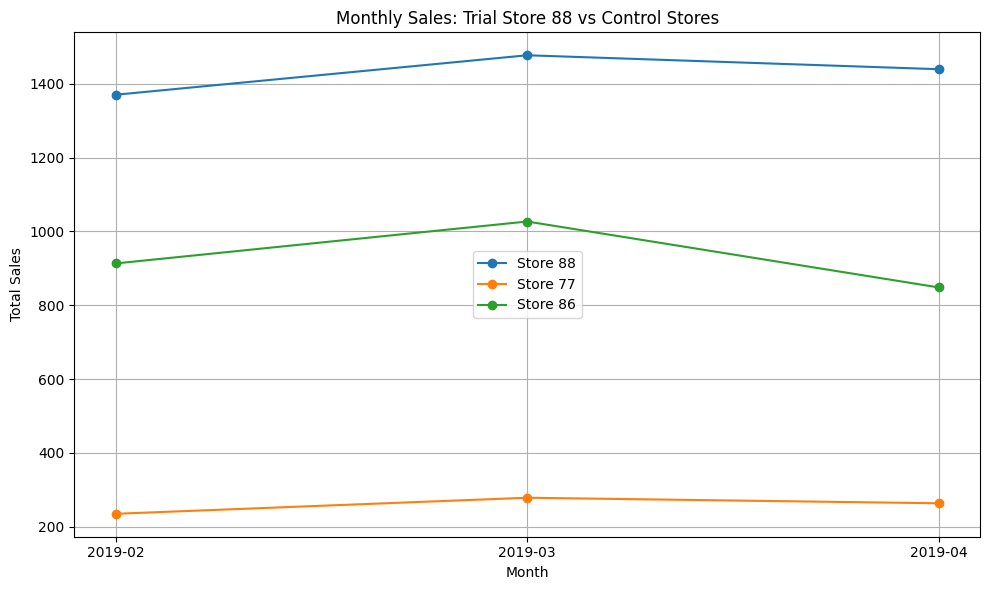

Summary for Trial Store 88
Month 2019-02: Control Store 77 - Corr: N/A, Sales Diff: 1135.20
Month 2019-03: Control Store 77 - Corr: 0.9999999999999499, Sales Diff: 1198.70
Month 2019-04: Control Store 77 - Corr: 0.9999999999999982, Sales Diff: 1175.90
Month 2019-02: Control Store 86 - Corr: N/A, Sales Diff: 457.00
Month 2019-03: Control Store 86 - Corr: 1.0000000000000162, Sales Diff: 450.40
Month 2019-04: Control Store 86 - Corr: 0.9999999999998718, Sales Diff: 591.20

----------------------------------------



In [38]:

def filter_data(df,stores,start_date,end_date):
    df['DATE']=pd.to_datetime(df['DATE'])
    return df[(df['STORE_NBR'].isin(stores))&(df['DATE']>=start_date)&(df['DATE']<=end_date)]

def aggregate_monthly_sales(df):
    df['YearMonth']=df['DATE'].dt.to_period('M')
    return df.groupby(['STORE_NBR','YearMonth'])['TOT_SALES'].sum().reset_index()

def select_controls_for_trial(trial_store,stores):
    return [s for s in stores if s!=trial_store]

def plot_monthly_sales(trial_store,control_stores,monthly_df):
    plt.figure(figsize=(10,6))
    for store in [trial_store]+control_stores:
        d=monthly_df[monthly_df['STORE_NBR']==store].sort_values('YearMonth')
        plt.plot(d['YearMonth'].astype(str),d['TOT_SALES'],marker='o',label=f'Store {store}')
    plt.xlabel('Month')
    plt.ylabel('Total Sales')
    plt.title(f'Monthly Sales: Trial Store {trial_store} vs Control Stores')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def print_monthly_summary(trial_store,control_stores,monthly_df):
    print(f"Summary for Trial Store {trial_store}")
    trial_data=monthly_df[monthly_df['STORE_NBR']==trial_store].set_index('YearMonth')
    for c in control_stores:
        c_data=monthly_df[monthly_df['STORE_NBR']==c].set_index('YearMonth')
        combined=trial_data.join(c_data,lsuffix='_trial',rsuffix='_control',how='inner')
        combined['corr']=combined['TOT_SALES_trial'].rolling(window=2).corr(combined['TOT_SALES_control'])
        for ym,row in combined.iterrows():
            corr=row['corr'] if not np.isnan(row['corr']) else 'N/A'
            diff=abs(row['TOT_SALES_trial']-row['TOT_SALES_control'])
            print(f"Month {ym}: Control Store {c} - Corr: {corr}, Sales Diff: {diff:.2f}")
    print('\n'+'-'*40+'\n')

stores=[77,86,88]
start_date='2019-02-01'
end_date='2019-04-30'

filtered_df=filter_data(dataset_1,stores,start_date,end_date)
monthly_sales=aggregate_monthly_sales(filtered_df)

for trial in stores:
    controls=select_controls_for_trial(trial,stores)
    plot_monthly_sales(trial,controls,monthly_sales)
    print_monthly_summary(trial,controls,monthly_sales)
